In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
para_data = pd.read_csv('/content/comp1804_coursework_dataset_23-24 (1).csv')

In [3]:
para_data.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity
0,428209002237,Ramsay was born in Glasgow on 2 October 1852. ...,ORG_YES_PRODUCT_NO_PERSON_YES_,49,12.0,man,biographies,clear_enough
1,564218010072,It has been widely estimated for at least the ...,ORG_YES_PRODUCT_NO_PERSON_NO_,166,47.0,man,artificial intelligence,not_clear_enough
2,291401001672,He went on to win the Royal Medal of the Royal...,ORG_YES_PRODUCT_NO_PERSON_NO_,69,18.0,non-binary,biographies,clear_enough
3,31548004883,The changes have altered many underlying assum...,ORG_NO_PRODUCT_YES_PERSON_NO_,76,27.0,non-binary,programming,clear_enough
4,50634005146,"After these novels were published, Disraeli de...",ORG_YES_PRODUCT_YES_PERSON_YES_,200,47.0,man,biographies,not_clear_enough


In [4]:
para_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9347 entries, 0 to 9346
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              9347 non-null   int64  
 1   paragraph           9347 non-null   object 
 2   has_entity          9347 non-null   object 
 3   lexicon_count       9347 non-null   int64  
 4   difficult_words     9329 non-null   float64
 5   last_editor_gender  9347 non-null   object 
 6   category            9286 non-null   object 
 7   text_clarity        9 non-null      object 
dtypes: float64(1), int64(2), object(5)
memory usage: 584.3+ KB


In [5]:
para_data.shape

(9347, 8)

In [6]:
para_data.isnull().sum()

par_id                   0
paragraph                0
has_entity               0
lexicon_count            0
difficult_words         18
last_editor_gender       0
category                61
text_clarity          9338
dtype: int64

In [7]:
# Data Preprocessing
para_data['difficult_words'] = para_data['difficult_words'].fillna(0)
para_data['category'] = para_data['category'].fillna('unknown')

In [8]:
para_data['category'].value_counts()

biographies                             2942
philosophy                              2585
programming                             1980
artificial intelligence                 1565
movies about artificial intelligence     166
unknown                                   61
Philosophy                                13
Biographies                               13
Artificial intelligence                   11
Programming                               10
Movies about artificial intelligence       1
Name: category, dtype: int64

In [9]:
para_data['category'] = para_data['category'].str.lower()

### EDA

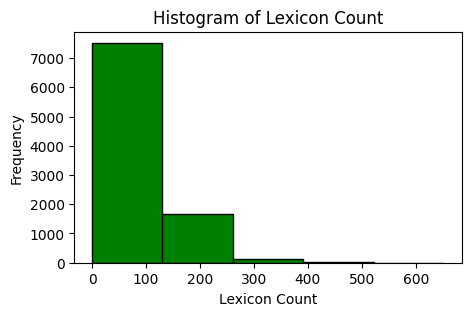

In [10]:
# Plotting histogram for 'lexicon_count'
plt.figure(figsize=(5,3))
plt.hist(para_data['lexicon_count'], bins=5, color='green', edgecolor='black')
plt.title('Histogram of Lexicon Count')
plt.xlabel('Lexicon Count')
plt.ylabel('Frequency')
plt.show()

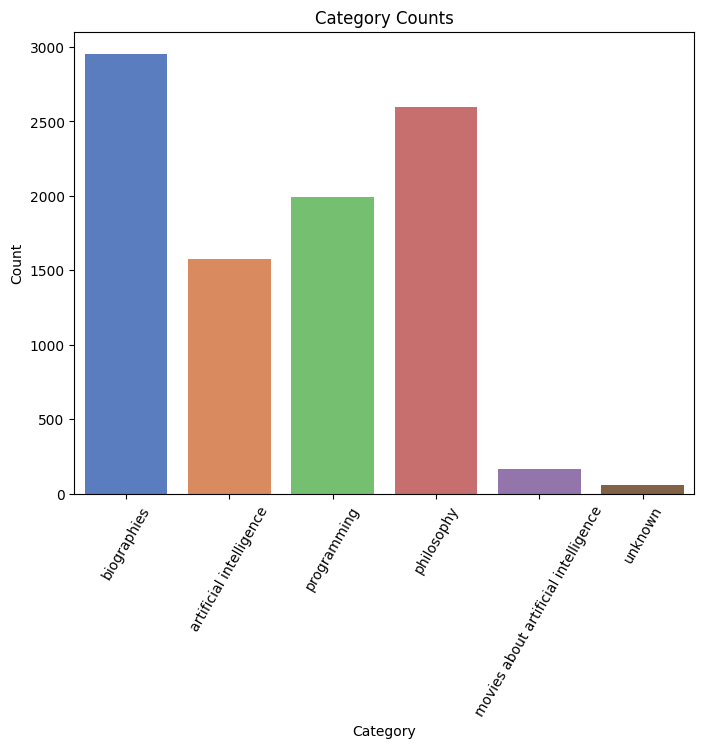

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=para_data, palette='muted')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

In [19]:
def preprocess_text_para(text):
    stemmer = PorterStemmer()

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens_lower = [word.lower() for word in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    tokens_filtered = [word for word in tokens_lower if word not in stop_words]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens_filtered]

    return ' '.join(stemmed_tokens)

para_data['preprocessed_paragraph'] = para_data['paragraph'].apply(preprocess_text_para)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(para_data[['preprocessed_paragraph',
                                                                   'has_entity']], para_data['category'],
                                                    test_size=0.2, random_state=125)

In [21]:
lab_enc = LabelEncoder()
X_train['has_entity'] = lab_enc.fit_transform(X_train['has_entity'])
X_test['has_entity'] = lab_enc.transform(X_test['has_entity'])

In [22]:
tfipara_data_vectorizer = TfidfVectorizer()
X_train_tfipara_data = tfipara_data_vectorizer.fit_transform(X_train['preprocessed_paragraph'])
X_test_tfipara_data = tfipara_data_vectorizer.transform(X_test['preprocessed_paragraph'])

In [23]:
X_train_has_entity = X_train['has_entity'].reset_index(drop=True).astype(str)
X_test_has_entity = X_test['has_entity'].reset_index(drop=True).astype(str)

# Horizontally stack the TF-IDF arrays and 'has_entity' column using np.hstack
X_train_combined = np.hstack((X_train_tfipara_data.toarray(), X_train_has_entity.values.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_tfipara_data.toarray(), X_test_has_entity.values.reshape(-1, 1)))

In [24]:
lrc = LogisticRegression()
lrc.fit(X_train_combined, y_train)

LogisticRegression()

In [25]:
lrc_pred = lrc.predict(X_test_combined)

In [26]:
accuracy = round(accuracy_score(y_test, lrc_pred)*100,2)
print(accuracy)

90.21


In [27]:
confusion_matrix(y_test, lrc_pred)

array([[261,  12,   0,  19,  11,   0],
       [  7, 557,   0,  31,   0,   0],
       [  2,   7,  20,   1,   2,   0],
       [  8,  33,   0, 469,   5,   0],
       [  9,   7,   0,  14, 380,   0],
       [  3,   2,   1,   5,   4,   0]])

In [28]:
print(classification_report(y_test, lrc_pred))

                                      precision    recall  f1-score   support

             artificial intelligence       0.90      0.86      0.88       303
                         biographies       0.90      0.94      0.92       595
movies about artificial intelligence       0.95      0.62      0.75        32
                          philosophy       0.87      0.91      0.89       515
                         programming       0.95      0.93      0.94       410
                             unknown       0.00      0.00      0.00        15

                            accuracy                           0.90      1870
                           macro avg       0.76      0.71      0.73      1870
                        weighted avg       0.90      0.90      0.90      1870



## b

In [29]:
# Check the baseline accuracy
baseline_accuracy = para_data['category'].value_counts(normalize=True).max()
baseline_accuracy

0.31614421739595594

In [30]:
y_tr_pr = lrc.predict(X_train_combined)
y_te_pr = lrc.predict(X_test_combined)

In [31]:
tr_acc = accuracy_score(y_train, y_tr_pr)
acc_test = accuracy_score(y_test, y_te_pr)

In [32]:
tr_acc

0.9650929517186038

In [33]:
acc_test

0.902139037433155

In [34]:

conf_matrix = confusion_matrix(y_test, y_te_pr)

misclf_per = {}

for i, category in enumerate(para_data['category'].unique()):
    misclf_per[category] = conf_matrix[i, :].sum() - conf_matrix[i, i] / conf_matrix[i, :].sum()

    print(f"Testing Misclassification Percentage for {category}: {misclf_per[category] * 100:.2f}%")

baseline_accuracy = max(conf_matrix.sum(axis=0)) / conf_matrix.sum()
acc_test = accuracy_score(y_test, y_te_pr)

if acc_test > baseline_accuracy:
    print("The model is better than the trivial baseline.")
else:
    print("The model does not outperform the trivial baseline.")

Testing Misclassification Percentage for biographies: 30213.86%
Testing Misclassification Percentage for artificial intelligence: 59406.39%
Testing Misclassification Percentage for programming: 3137.50%
Testing Misclassification Percentage for philosophy: 51408.93%
Testing Misclassification Percentage for movies about artificial intelligence: 40907.32%
Testing Misclassification Percentage for unknown: 1500.00%
The model is better than the trivial baseline.


## c

In [35]:
# Calculate precision, recall, and F1-score
precision_lrc = precision_score(y_test, lrc_pred, average='macro')
f1_lrc = f1_score(y_test, lrc_pred, average='macro')
recall_lrc = recall_score(y_test, lrc_pred, average='macro')

In [36]:
print("Precision:", precision_lrc)
print("F1-score:", f1_lrc)
print("Recall:", recall_lrc)

Precision: 0.7615131587889158
F1-score: 0.7298791053745143
Recall: 0.7100049120564238


# Task 2

In [37]:
import random

In [38]:
random.seed(121)
clarity = para_data.sample(n=100, random_state=121).copy()
clarity['text_clarity'] = [random.choice(['clear_enough', 'not_clear_enough']) for _ in range(100)]

In [39]:
clarity.to_csv("clarity_data.csv", index=False)

In [40]:
clarity.head()

,par_id,paragraph,has_entity,lexicon_count,difficult_words,last_editor_gender,category,text_clarity,preprocessed_paragraph
4990,745893011297,Clippy is Rust's built-in linting tool to impr...,ORG_YES_PRODUCT_NO_PERSON_NO_,52,14.0,man,programming,clear_enough,clippi rust 's built-in lint tool improv corre...
4055,314496008689,Others have argued that the belief may not be ...,ORG_YES_PRODUCT_NO_PERSON_YES_,180,50.0,woman,philosophy,clear_enough,other argu belief may inher maccabees.in first...
591,392496009362,Later BASIC versions on Commodore and other pl...,ORG_YES_PRODUCT_NO_PERSON_NO_,76,26.0,man,programming,not_clear_enough,later basic version commodor platform includ d...
2606,686523011071,"""This World 2 is our primary reality. Our cons...",ORG_NO_PRODUCT_NO_PERSON_NO_,159,36.0,man,biographies,clear_enough,`` world 2 primari realiti . consciou experi b...
2593,13149004382,Aesthetics examines affective domain response ...,ORG_NO_PRODUCT_NO_PERSON_NO_,32,16.0,man,philosophy,clear_enough,aesthet examin affect domain respons object ph...


In [41]:
X_train, X_test, y_train, y_test = train_test_split(clarity['paragraph'], clarity['text_clarity'],
                                                    test_size=0.2)

In [42]:
# Feature extraction using TF-Ipara_data
tfipara_data_vectorizer = TfidfVectorizer()
X_train_tfipara_data = tfipara_data_vectorizer.fit_transform(X_train)
X_test_tfipara_data = tfipara_data_vectorizer.transform(X_test)

In [43]:
from sklearn.ensemble import AdaBoostClassifier

In [44]:
# Model Training
aboost = AdaBoostClassifier()
aboost.fit(X_train_tfipara_data, y_train)

AdaBoostClassifier()

In [45]:
# Model Evaluation
logreg_pred = aboost.predict(X_test_tfipara_data)
accuracy_score(y_test, logreg_pred)

0.35

In [46]:
print("Classification Report:\n", classification_report(y_test, logreg_pred))

Classification Report:
                   precision    recall  f1-score   support

    clear_enough       0.38      0.27      0.32        11
not_clear_enough       0.33      0.44      0.38         9

        accuracy                           0.35        20
       macro avg       0.35      0.36      0.35        20
    weighted avg       0.36      0.35      0.35        20

